In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


# Loading Data

In [2]:
whole_data = np.load('../../Data_Preprocessing/output/500_Dataset/training_data.npy')
whole_labels_cub = np.load('../../Data_Preprocessing/output/500_Dataset/training_dists_cub.npy')
whole_labels_flatten = np.load('../../Data_Preprocessing/output/500_Dataset/training_dists_flatten.npy')

In [3]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

OUTPUT_DIST_NUM = int((BRANCH_NUM - 1) * BRANCH_NUM / 2)

In [4]:
print(whole_data.shape)
print(whole_labels_cub.shape)
print(whole_labels_flatten.shape)

(500, 100, 1000, 1)
(500, 100, 100, 1)
(500, 4950)


### Plot before shuffle

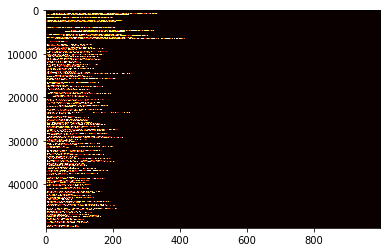

In [5]:
whole_data_before_shuffle = whole_data.reshape((whole_data.shape[0]*100, 1000))
plt.imshow(whole_data_before_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

## Shuffle each input sampe (dim: 100 * 1000)

#### Use the different index for all input sample

In [6]:
# shuffle_indices_100 = random.sample(range(0, 100), 100)
# shuffle_indices_1000 = random.sample(range(0, 1000), 1000)

In [7]:
for i in range(whole_data.shape[0]):
    shuffle_indices_100 = random.sample(range(0, 100), 100)
    shuffle_indices_1000 = random.sample(range(0, 1000), 1000)
    tmp = whole_data[i][shuffle_indices_100]
    tmp = tmp[:, shuffle_indices_1000]
    whole_data[i] = tmp

### Plot after shuffle

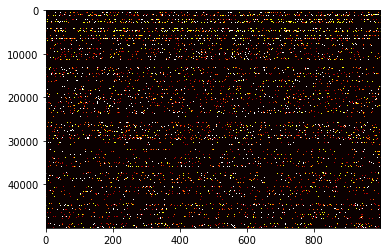

In [8]:
whole_data_after_shuffle = whole_data.reshape((whole_data.shape[0]*100, 1000))
plt.imshow(whole_data_after_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

# Training Testing Dataset Partition

In [9]:
samples_count = whole_data.shape[0]

train_size = math.floor(0.85*whole_data.shape[0])

shuffle_indices = random.sample(range(0, samples_count), samples_count)

print(len(np.unique(shuffle_indices)))

500


In [10]:
indices_train = shuffle_indices[0:train_size]
indices_test = shuffle_indices[train_size:samples_count]

In [11]:
print("######## Training Data ########")
X_train = whole_data[indices_train,:]
Y_train_cub = whole_labels_cub[indices_train]
Y_train_flatten = whole_labels_flatten[indices_train]

print("######## Validation Data ########")
X_test = whole_data[indices_test,:]
Y_test_cub = whole_labels_cub[indices_test]
Y_test_flatten = whole_labels_flatten[indices_test]

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', Y_train_cub.shape)

print('Y_train_cub.shape : ', Y_train_cub.shape)
print('Y_test_cub.shape : ', Y_test_cub.shape)
print('Y_train_flatten.shape : ', Y_train_flatten.shape)
print('Y_test_flatten.shape : ', Y_test_flatten.shape)# Training Testing Dataset Partition

######## Training Data ########
######## Validation Data ########
X_train.shape :  (425, 100, 1000, 1)
X_test.shape :  (425, 100, 100, 1)
Y_train_cub.shape :  (425, 100, 100, 1)
Y_test_cub.shape :  (75, 100, 100, 1)
Y_train_flatten.shape :  (425, 4950)
Y_test_flatten.shape :  (75, 4950)


### Plot for shuffled X_train (samples)

In [12]:
X_train_shuffle = X_train.reshape((X_train.shape[0]*100, 1000))

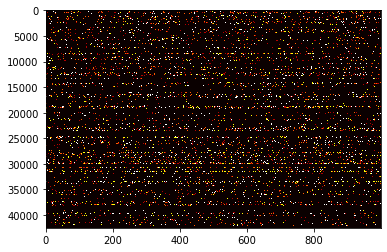

In [13]:
plt.imshow(X_train_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Plot for shuffled X_test (samples)

In [14]:
X_test_shuffle = X_test.reshape((X_test.shape[0]*100, 1000))

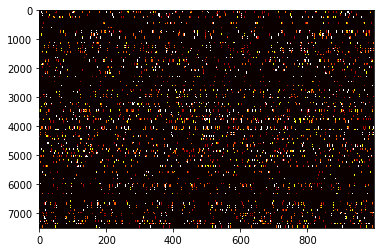

In [15]:
plt.imshow(X_test_shuffle, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

In [16]:
np.save('./output/X_train.npy', X_train)
np.save('./output/Y_train_cub.npy', Y_train_cub)
np.save('./output/Y_train_flatten.npy', Y_train_flatten)

np.save('./output/X_test.npy', X_test)
np.save('./output/Y_test_cub.npy', Y_test_cub)
np.save('./output/Y_test_flatten.npy', Y_test_flatten)

### Load Data

In [17]:
# X_train = np.load('./output/X_train.npy')
# Y_train_cub = np.load('./output/Y_train_cub.npy')
# Y_train_flatten = np.load('./output/Y_train_flatten.npy')

# X_test = np.load('./output/X_test.npy')
# Y_test_cub = np.load('./output/Y_test_cub.npy')
# Y_test_flatten = np.load('./output/Y_test_flatten.npy')

In [18]:
# model = Sequential()

# # Layer 1
# model.add(Conv2D(64, input_shape=X_train.shape[1:], kernel_size=(3,3), strides=(1,1), padding='same'))
# #model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 2
# model.add(Conv2D(32, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 3
# model.add(Conv2D(16, (3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(1, 2)))

# # Layer 4
# model.add(Conv2D(1, (2, 1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(1, 2)))


In [21]:
model = Sequential()

# Layer 1
model.add(Conv2D(100, input_shape=X_train.shape[1:], kernel_size=(100,1), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 2
model.add(Conv2D(10, (1, 4), padding='SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 3
model.add(Conv2D(5, (1, 4), padding='SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 4
model.add(Conv2D(1, (1, 4), padding='SAME'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 1000, 100)      10100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1000, 100)      400       
_________________________________________________________________
activation_5 (Activation)    (None, 1, 1000, 100)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1000, 100)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1000, 10)       4010      
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 1000, 10)       40        
_________________________________________________________________
activation_6 (Activation)    (None, 1, 1000, 10)      

In [23]:
# def log_loss:
#     if not K.is_tensor(y_pred):
#         y_pred = K.constant(y_pred)
#     y_true = K.cast(y_true, y_pred.dtype)
    
#     return K.log(K.square(y_pred - y_true), axis=-1)

In [24]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])

In [25]:
loss_list_epoch= []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

In [26]:
## This function is defined for vector -> symmetric distance matrix
def utri2mat(utri):
    n = (int(-1 + np.sqrt(1 + 8*len(utri))) // 2) + 1
    iu1 = np.triu_indices(n-1)
    iu1 = (iu1[0], iu1[1] + 1)
    ret = np.zeros((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [27]:
# Do first time to initial the tree!
print("******** Start fitting model ********")
history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=50, epochs=1, verbose=1)
print(history.history['loss'])
loss_list_epoch.append(history.history['loss'][0])

print("******** Start calculating RF Distance ********")
RF_list_distance = []
for index in range(len(X_train)):
    tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
    array_selection_length = int((tips_num + 1) * tips_num / 2)
    Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
    X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
    X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
    original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
    new_dis_matrix = utri2mat(X_train_results_vec_sel)
    for i in range(len(new_dis_matrix)):
        new_dis_matrix[i,i] = 0
    with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(original_dis_matrix)
    with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(new_dis_matrix)
    taxon_namespace = dendropy.TaxonSet()
    pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    tree_origin = pdm_origin.nj_tree()
    tree_new = pdm_new.nj_tree()
    RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
    RF_list_distance.append(RF_distance)
RF_list_distance_epoch.append(RF_list_distance)
RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
print("RF_list_distance: ", RF_list_distance)
print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 425 samples, validate on 75 samples
Epoch 1/1
425/425 [==============================] - 2s 4ms/step - loss: 0.0590 - accuracy: 0.0000e+00 - val_loss: 0.0865 - val_accuracy: 0.0000e+00
[0.059046657208134144]
******** Start calculating RF Distance ********


/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [114, 136, 128, 124, 72, 126, 98, 118, 116, 120, 96, 114, 120, 116, 118, 98, 122, 126, 114, 76, 112, 124, 110, 136, 128, 116, 130, 118, 98, 112, 96, 102, 112, 70, 110, 112, 124, 110, 114, 140, 128, 106, 128, 112, 122, 112, 106, 126, 118, 126, 122, 114, 126, 110, 110, 130, 104, 72, 132, 120, 74, 124, 66, 110, 128, 138, 136, 136, 42, 84, 82, 116, 132, 134, 112, 120, 84, 124, 114, 114, 128, 100, 94, 130, 76, 130, 108, 136, 48, 126, 144, 116, 130, 118, 128, 106, 118, 130, 128, 128, 130, 122, 134, 120, 124, 90, 110, 126, 112, 128, 128, 110, 126, 52, 142, 136, 78, 104, 112, 110, 98, 126, 118, 130, 112, 118, 128, 118, 116, 106, 130, 48, 62, 128, 130, 46, 102, 128, 76, 48, 140, 140, 130, 122, 136, 116, 128, 132, 120, 72, 126, 96, 102, 102, 106, 114, 132, 110, 124, 58, 114, 132, 120, 126, 124, 118, 116, 96, 128, 128, 138, 110, 120, 134, 140, 120, 82, 136, 128, 130, 114, 122, 126, 114, 128, 134, 102, 124, 102, 110, 84, 124, 134, 110, 114, 128, 110, 98, 114, 132, 98, 118, 108, 

In [28]:
# (5) Train
# history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=16, epochs=10, verbose=1)
for i in range(10):
    print("******** Start fitting model ********")
    history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=2, epochs=50, verbose=1)
    print(history.history['loss'])
    loss_list_epoch.append(history.history['loss'][0])

    print("******** Start calculating RF Distance ********")
    RF_list_distance = []
    for index in range(len(X_train)):
        tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
        array_selection_length = int((tips_num + 1) * tips_num / 2)
        Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
        X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
        X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
        original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
        new_dis_matrix = utri2mat(X_train_results_vec_sel)
        for i in range(len(new_dis_matrix)):
            new_dis_matrix[i,i] = 0
        with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(original_dis_matrix)
        with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(new_dis_matrix)
        taxon_namespace = dendropy.TaxonSet()
        pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        tree_origin = pdm_origin.nj_tree()
        tree_new = pdm_new.nj_tree()
        RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
        RF_list_distance.append(RF_distance)
    RF_list_distance_epoch.append(RF_list_distance)
    RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
    print("RF_list_distance: ", RF_list_distance)
    print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 425 samples, validate on 75 samples
Epoch 1/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0516 - accuracy: 0.0047 - val_loss: 0.0482 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0471 - accuracy: 0.0024 - val_loss: 0.0483 - val_accuracy: 0.0133
Epoch 3/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0417 - accuracy: 0.0118 - val_loss: 0.0523 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0376 - accuracy: 0.0094 - val_loss: 0.0472 - val_accuracy: 0.0133
Epoch 5/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0332 - accuracy: 0.0118 - val_loss: 0.0513 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0301 - accuracy: 0.0353 - val_loss: 0.0600 - val_accuracy: 0.0000e+00
Epoch 7/50
425/425 [=======================

/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [108, 138, 130, 120, 38, 120, 90, 114, 112, 118, 86, 108, 112, 110, 116, 80, 110, 118, 112, 54, 106, 118, 104, 132, 122, 110, 126, 110, 90, 102, 92, 92, 104, 70, 96, 110, 126, 108, 110, 138, 128, 98, 108, 104, 116, 110, 106, 122, 106, 120, 118, 102, 114, 94, 102, 128, 92, 72, 128, 114, 54, 120, 54, 96, 126, 126, 132, 130, 10, 74, 80, 108, 132, 130, 110, 110, 80, 114, 106, 112, 126, 90, 76, 128, 60, 118, 106, 124, 20, 124, 136, 112, 118, 110, 124, 104, 110, 130, 124, 124, 130, 108, 134, 112, 116, 80, 94, 126, 106, 122, 126, 98, 114, 50, 136, 126, 58, 102, 96, 98, 86, 120, 106, 126, 106, 118, 124, 114, 108, 88, 126, 40, 60, 124, 122, 12, 98, 124, 64, 36, 140, 134, 124, 124, 134, 110, 110, 126, 112, 72, 122, 76, 102, 90, 100, 110, 124, 102, 120, 50, 108, 120, 112, 122, 118, 94, 92, 96, 128, 128, 132, 100, 110, 134, 130, 108, 82, 126, 122, 120, 108, 110, 124, 102, 122, 128, 86, 118, 100, 110, 80, 120, 128, 104, 112, 116, 106, 90, 104, 120, 90, 106, 76, 88, 128, 112, 124,

Epoch 42/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0107 - accuracy: 0.5318 - val_loss: 0.0611 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0106 - accuracy: 0.5318 - val_loss: 0.0618 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0105 - accuracy: 0.5106 - val_loss: 0.0613 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0103 - accuracy: 0.4871 - val_loss: 0.0622 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0102 - accuracy: 0.5294 - val_loss: 0.0606 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0101 - accuracy: 0.5082 - val_loss: 0.0604 - val_accuracy: 0.0000e+00
Epoch 48/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0101 - accuracy: 0.5082 - val_loss

425/425 [==============================] - 5s 12ms/step - loss: 0.0088 - accuracy: 0.5882 - val_loss: 0.0602 - val_accuracy: 0.0000e+00
Epoch 26/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0088 - accuracy: 0.5553 - val_loss: 0.0590 - val_accuracy: 0.0000e+00
Epoch 27/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0087 - accuracy: 0.5647 - val_loss: 0.0636 - val_accuracy: 0.0000e+00
Epoch 28/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0086 - accuracy: 0.5812 - val_loss: 0.0607 - val_accuracy: 0.0000e+00
Epoch 29/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0086 - accuracy: 0.5953 - val_loss: 0.0627 - val_accuracy: 0.0000e+00
Epoch 30/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0086 - accuracy: 0.5859 - val_loss: 0.0619 - val_accuracy: 0.0000e+00
Epoch 31/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0086 - accuracy: 0.6165 - val_loss: 0.0610 - v

425/425 [==============================] - 5s 12ms/step - loss: 0.0081 - accuracy: 0.6141 - val_loss: 0.0608 - val_accuracy: 0.0133
Epoch 9/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0081 - accuracy: 0.6424 - val_loss: 0.0618 - val_accuracy: 0.0133
Epoch 10/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0081 - accuracy: 0.6118 - val_loss: 0.0597 - val_accuracy: 0.0000e+00
Epoch 11/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0081 - accuracy: 0.6376 - val_loss: 0.0597 - val_accuracy: 0.0133
Epoch 12/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0080 - accuracy: 0.6376 - val_loss: 0.0607 - val_accuracy: 0.0133
Epoch 13/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0080 - accuracy: 0.6000 - val_loss: 0.0609 - val_accuracy: 0.0133
Epoch 14/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0081 - accuracy: 0.6282 - val_loss: 0.0597 - val_accuracy: 0.0133
E

425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6871 - val_loss: 0.0617 - val_accuracy: 0.0133
Epoch 2/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0077 - accuracy: 0.6518 - val_loss: 0.0617 - val_accuracy: 0.0133
Epoch 3/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6565 - val_loss: 0.0606 - val_accuracy: 0.0133
Epoch 4/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6800 - val_loss: 0.0619 - val_accuracy: 0.0133
Epoch 5/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6635 - val_loss: 0.0595 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6824 - val_loss: 0.0615 - val_accuracy: 0.0133
Epoch 7/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0076 - accuracy: 0.6706 - val_loss: 0.0603 - val_accuracy: 0.0133
Epoch 

RF_list_distance:  [108, 138, 116, 116, 2, 112, 64, 106, 98, 102, 80, 94, 104, 94, 118, 66, 106, 108, 110, 36, 112, 112, 94, 128, 114, 104, 112, 116, 84, 98, 72, 44, 84, 68, 94, 102, 126, 98, 110, 132, 124, 88, 106, 108, 122, 104, 96, 112, 106, 114, 102, 102, 110, 88, 98, 124, 84, 72, 124, 108, 50, 90, 54, 88, 100, 128, 128, 118, 0, 68, 72, 104, 114, 128, 102, 96, 84, 106, 102, 96, 118, 38, 62, 118, 46, 114, 94, 122, 16, 118, 144, 96, 116, 104, 116, 100, 102, 128, 124, 118, 124, 112, 126, 120, 112, 72, 78, 122, 78, 124, 120, 82, 108, 32, 132, 122, 56, 82, 98, 94, 68, 120, 94, 126, 106, 116, 120, 118, 104, 88, 120, 40, 48, 122, 118, 18, 98, 116, 66, 38, 136, 138, 118, 122, 134, 108, 116, 124, 98, 72, 116, 42, 102, 92, 82, 90, 124, 92, 114, 52, 96, 124, 102, 116, 118, 94, 106, 96, 128, 120, 122, 88, 98, 136, 132, 112, 80, 124, 122, 118, 94, 104, 120, 102, 120, 120, 76, 116, 94, 98, 64, 116, 130, 90, 114, 124, 90, 70, 106, 118, 74, 106, 78, 64, 126, 100, 112, 60, 122, 96, 106, 108, 106, 1

425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.7224 - val_loss: 0.0614 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.6988 - val_loss: 0.0620 - val_accuracy: 0.0133
Epoch 44/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.7012 - val_loss: 0.0607 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0072 - accuracy: 0.7271 - val_loss: 0.0626 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0072 - accuracy: 0.7153 - val_loss: 0.0621 - val_accuracy: 0.0133
Epoch 47/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0072 - accuracy: 0.7082 - val_loss: 0.0607 - val_accuracy: 0.0133
Epoch 48/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.7153 - val_loss: 0.0619 - val_accuracy:

425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.7341 - val_loss: 0.0614 - val_accuracy: 0.0000e+00
Epoch 26/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.7247 - val_loss: 0.0615 - val_accuracy: 0.0133
Epoch 27/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0071 - accuracy: 0.6965 - val_loss: 0.0618 - val_accuracy: 0.0000e+00
Epoch 28/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0070 - accuracy: 0.6941 - val_loss: 0.0622 - val_accuracy: 0.0133
Epoch 29/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0070 - accuracy: 0.7176 - val_loss: 0.0631 - val_accuracy: 0.0000e+00
Epoch 30/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0070 - accuracy: 0.7365 - val_loss: 0.0624 - val_accuracy: 0.0000e+00
Epoch 31/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0070 - accuracy: 0.7059 - val_loss: 0.0614 - val_accur

425/425 [==============================] - 6s 14ms/step - loss: 0.0069 - accuracy: 0.7365 - val_loss: 0.0615 - val_accuracy: 0.0133
Epoch 9/50
425/425 [==============================] - 6s 14ms/step - loss: 0.0069 - accuracy: 0.7482 - val_loss: 0.0620 - val_accuracy: 0.0133
Epoch 10/50
425/425 [==============================] - 6s 15ms/step - loss: 0.0069 - accuracy: 0.7553 - val_loss: 0.0619 - val_accuracy: 0.0133
Epoch 11/50
425/425 [==============================] - 5s 13ms/step - loss: 0.0069 - accuracy: 0.7176 - val_loss: 0.0619 - val_accuracy: 0.0133
Epoch 12/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0069 - accuracy: 0.7318 - val_loss: 0.0618 - val_accuracy: 0.0133
Epoch 13/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0069 - accuracy: 0.7200 - val_loss: 0.0621 - val_accuracy: 0.0133
Epoch 14/50
425/425 [==============================] - 5s 13ms/step - loss: 0.0069 - accuracy: 0.7388 - val_loss: 0.0623 - val_accuracy: 0.0133
Epoch

425/425 [==============================] - 7s 16ms/step - loss: 0.0069 - accuracy: 0.7271 - val_loss: 0.0629 - val_accuracy: 0.0133
Epoch 2/50
425/425 [==============================] - 7s 16ms/step - loss: 0.0069 - accuracy: 0.7600 - val_loss: 0.0615 - val_accuracy: 0.0133
Epoch 3/50
425/425 [==============================] - 7s 15ms/step - loss: 0.0069 - accuracy: 0.7624 - val_loss: 0.0623 - val_accuracy: 0.0133
Epoch 4/50
425/425 [==============================] - 6s 15ms/step - loss: 0.0068 - accuracy: 0.7388 - val_loss: 0.0617 - val_accuracy: 0.0133
Epoch 5/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0068 - accuracy: 0.7388 - val_loss: 0.0613 - val_accuracy: 0.0133
Epoch 6/50
425/425 [==============================] - 5s 13ms/step - loss: 0.0068 - accuracy: 0.7341 - val_loss: 0.0620 - val_accuracy: 0.0133
Epoch 7/50
425/425 [==============================] - 5s 13ms/step - loss: 0.0068 - accuracy: 0.7529 - val_loss: 0.0619 - val_accuracy: 0.0133
Epoch 8/50

RF_list_distance:  [110, 138, 122, 112, 4, 108, 54, 104, 100, 104, 70, 96, 110, 94, 116, 76, 110, 102, 102, 34, 106, 110, 90, 126, 118, 96, 112, 116, 86, 88, 76, 58, 90, 64, 90, 100, 124, 100, 108, 134, 124, 88, 104, 100, 118, 106, 94, 108, 98, 106, 108, 110, 104, 90, 94, 124, 86, 72, 128, 104, 52, 96, 56, 86, 100, 126, 128, 118, 2, 62, 72, 104, 118, 128, 106, 106, 84, 106, 100, 96, 118, 62, 40, 114, 52, 110, 98, 120, 6, 116, 136, 96, 116, 106, 116, 102, 104, 128, 122, 116, 122, 104, 128, 118, 116, 82, 92, 102, 82, 124, 124, 80, 98, 36, 132, 124, 44, 84, 96, 94, 40, 118, 104, 122, 94, 118, 124, 118, 80, 94, 118, 26, 54, 122, 118, 18, 98, 116, 64, 36, 138, 134, 114, 120, 128, 96, 108, 128, 96, 72, 114, 66, 102, 86, 88, 100, 120, 90, 112, 48, 98, 132, 110, 116, 118, 96, 94, 94, 128, 122, 122, 78, 98, 134, 126, 112, 82, 124, 112, 122, 94, 102, 120, 102, 110, 130, 70, 118, 90, 102, 54, 106, 128, 86, 114, 120, 102, 58, 100, 120, 76, 102, 68, 62, 126, 102, 120, 54, 120, 82, 108, 114, 104, 13

425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7600 - val_loss: 0.0626 - val_accuracy: 0.0133
Epoch 43/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7553 - val_loss: 0.0637 - val_accuracy: 0.0133
Epoch 44/50
425/425 [==============================] - 5s 13ms/step - loss: 0.0067 - accuracy: 0.7600 - val_loss: 0.0622 - val_accuracy: 0.0133
Epoch 45/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7553 - val_loss: 0.0635 - val_accuracy: 0.0133
Epoch 46/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7576 - val_loss: 0.0621 - val_accuracy: 0.0133
Epoch 47/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7388 - val_loss: 0.0639 - val_accuracy: 0.0133
Epoch 48/50
425/425 [==============================] - 5s 12ms/step - loss: 0.0067 - accuracy: 0.7694 - val_loss: 0.0637 - val_accuracy: 0.0133
Epoc

In [29]:
model.save('./output/CNN_model_03.h5')

In [30]:
train_result = model.evaluate(X_train, Y_train_flatten)
test_result = model.evaluate(X_test, Y_test_flatten)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

75/75 [==============================] - 0s 1ms/step
Train Acc:  [0.006890325488193946, 0.7599999904632568]
Test Acc:  [0.06348698288202285, 0.013333333656191826]


## Load the Model

In [31]:
# model = keras.models.load_model('./output/CNN_model_03.h5')

## X_train plot

In [32]:
X_train_results = model.predict(X_train)

In [33]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

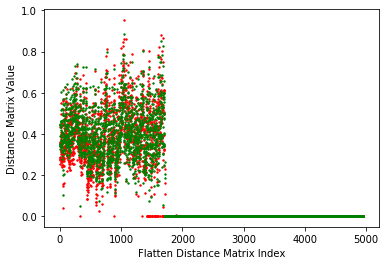

In [34]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_flatten[train_show_index].shape[0]), Y_train_flatten[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

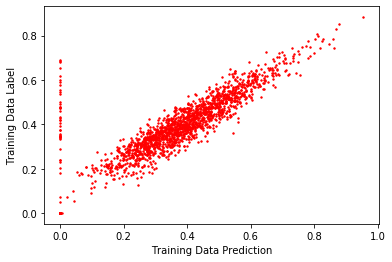

In [35]:
plt.scatter(X_train_results[train_show_index], Y_train_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [36]:
X_train_results_resh= X_train_results.reshape((1, 425*OUTPUT_DIST_NUM))
Y_train_resh = Y_train_flatten.reshape((1, 425*OUTPUT_DIST_NUM))

<function matplotlib.pyplot.show(*args, **kw)>

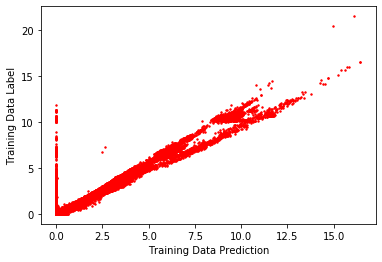

In [37]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot

In [38]:
X_test_results = model.predict(X_test)

In [39]:
test_show_index = 10

Text(0, 0.5, 'Distance Matrix Value')

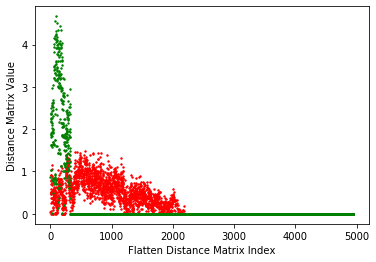

In [40]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test_flatten[test_show_index].shape[0]), Y_test_flatten[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

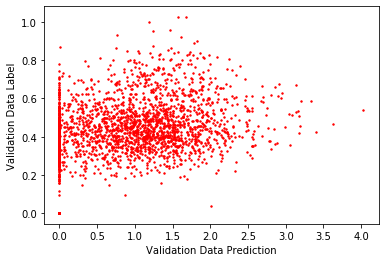

In [41]:
plt.scatter(X_test_results[train_show_index], Y_test_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [42]:
X_test_results_resh= X_test_results.reshape((1, 75*OUTPUT_DIST_NUM))
Y_test_resh = Y_test_flatten.reshape((1, 75*OUTPUT_DIST_NUM))

<function matplotlib.pyplot.show(*args, **kw)>

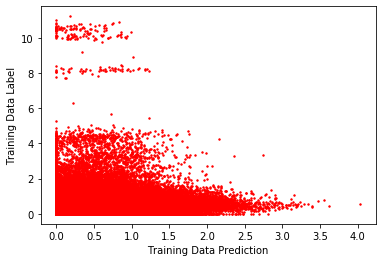

In [43]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot Loss 

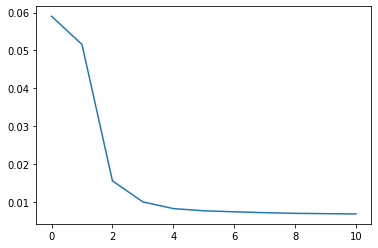

In [44]:
plt.plot(loss_list_epoch)
plt.show()

## Plot RF distance

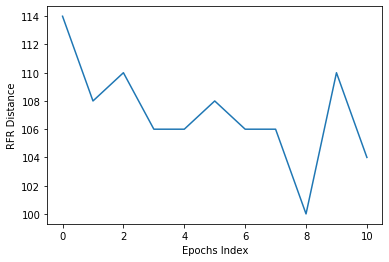

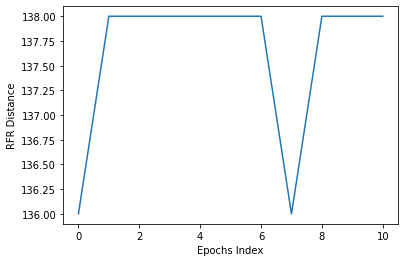

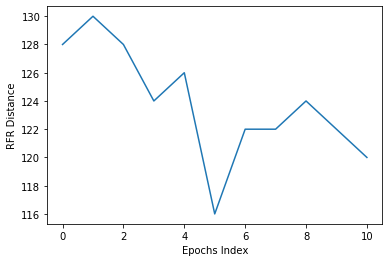

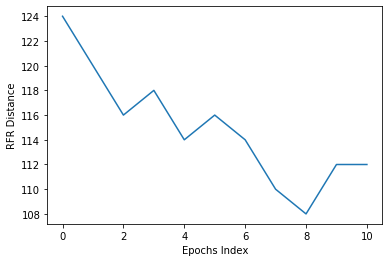

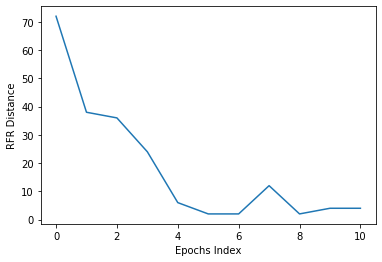

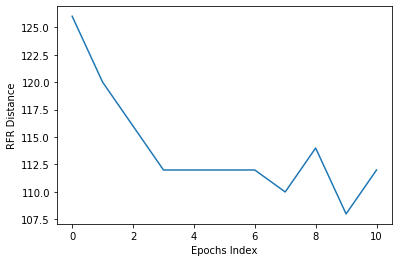

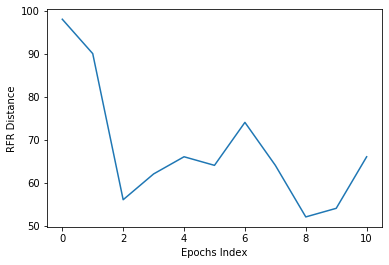

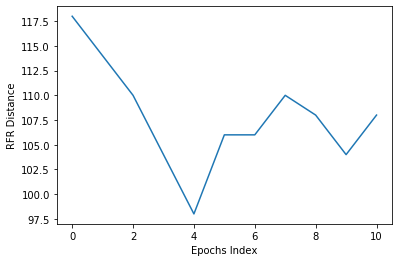

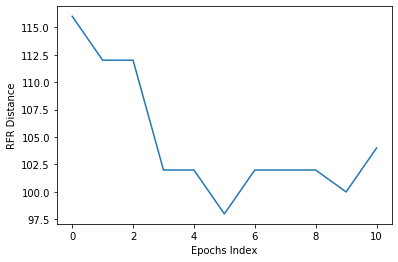

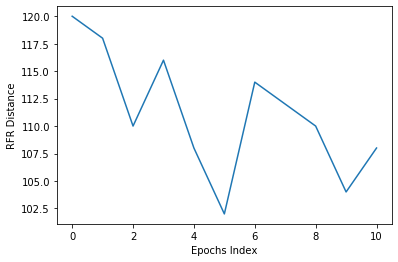

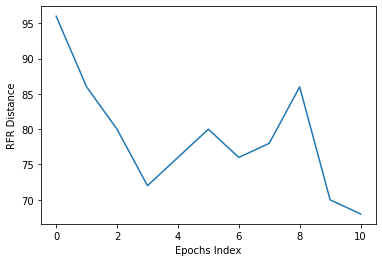

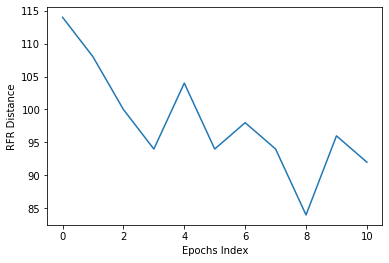

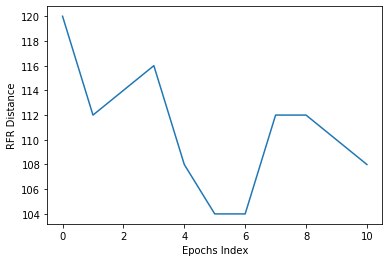

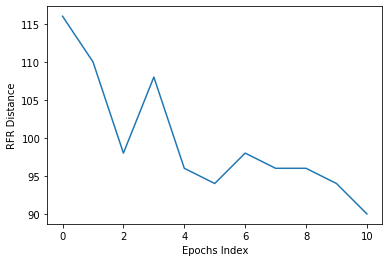

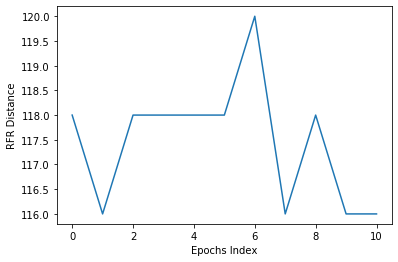

In [45]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

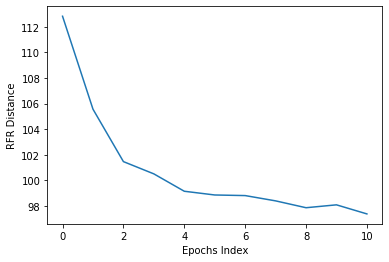

In [46]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()